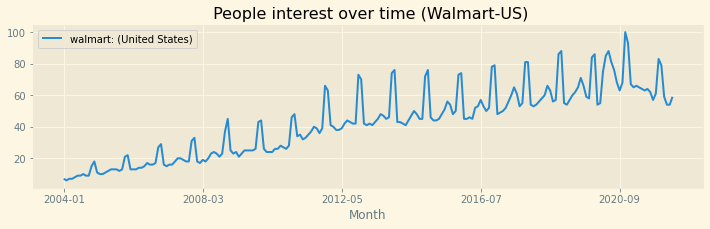

In [1]:
# importing libreries and changing their name
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('Solarize_Light2')

data=pd.read_csv('walmart.csv',header=1,parse_dates=True)
data
df = pd.DataFrame(data, columns=['Month','walmart: (United States)']).set_index('Month')
size=len(df)-int(len(df)*0.2)
train = df.iloc[:size, :]
test = df.iloc[size:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));
plt.title(" People interest over time (Walmart-US)");

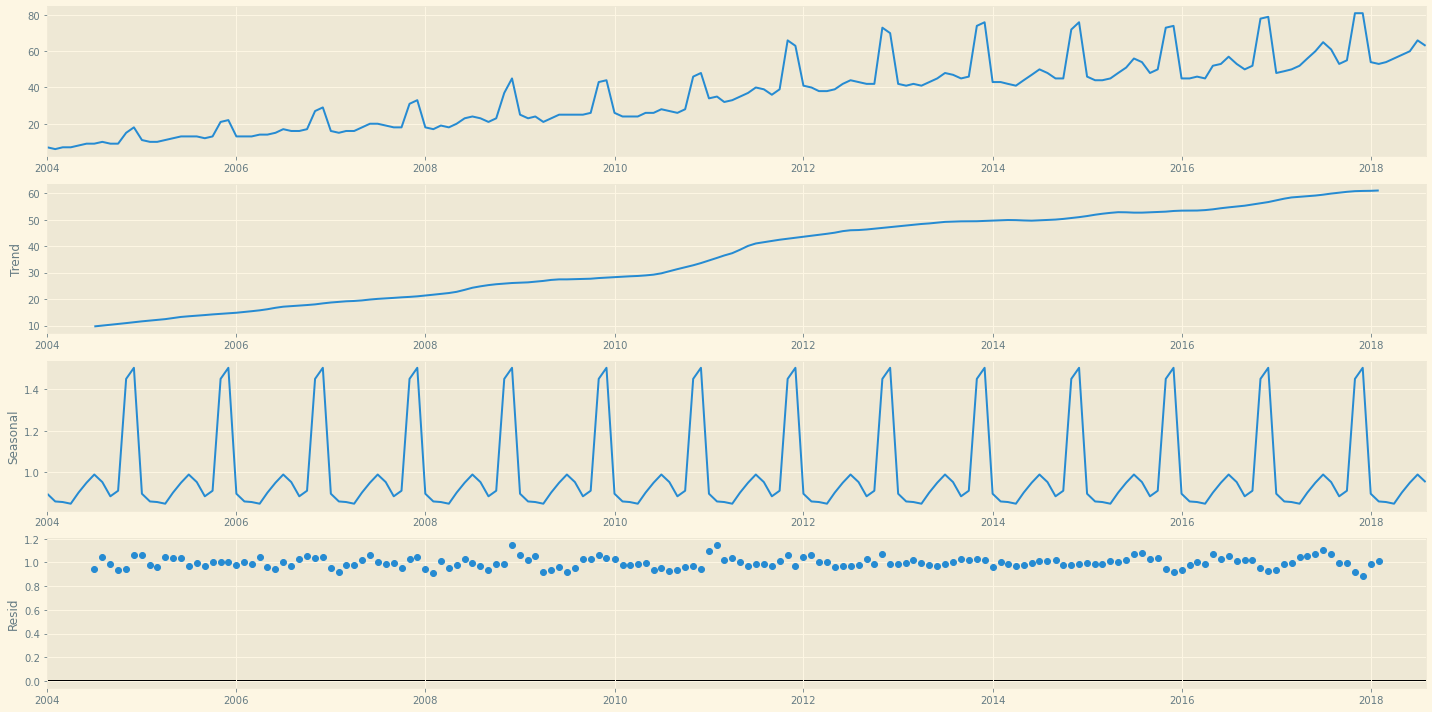

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(train, model = 'multiplicative')
fig = decomposition.plot()
plt.show()

In [ ]:
fig, ax = plt.subplots(3, figsize=(12,6))
x = (train.station.dropna() - train.station.dropna().shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [3]:
train['z_data'] = (train['walmart: (United States)'] - train['walmart: (United States)'].rolling(window=12).mean()) / train['walmart: (United States)'].rolling(window=12).std()
train['zp_data'] = train['z_data'] - train['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    dftest = adfuller(train['walmart: (United States)'], autolag='AIC')
    ax[0].plot(train.index, train['walmart: (United States)'], label='raw data')
    ax[0].plot(train['walmart: (United States)'].rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(train['walmart: (United States)'].rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()
  
    ax[1].plot(train.index, train['z_data'], label="de-trended data")
    ax[1].plot(train['z_data'].rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(train['z_data'].rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(train.index, train['zp_data'], label="12 lag differenced de-trended data")
    ax[2].plot(train['zp_data'].rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(train['zp_data'].rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

In [130]:
from statsmodels.tsa.stattools import adfuller

print("Is the data stationary ?")
dftest = adfuller(train['walmart: (United States)'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n Is the de-trended data stationary ?")
dftest = adfuller(train['z_data'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(train['zp_data'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Is the data stationary ?
Test statistic = -0.727
P-value = 0.840
Critical values :
	1%: -3.471374345647024 - The data is not stationary with 99% confidence
	5%: -2.8795521079291966 - The data is not stationary with 95% confidence
	10%: -2.5763733302850174 - The data is not stationary with 90% confidence

 Is the de-trended data stationary ?
Test statistic = -2.808
P-value = 0.057
Critical values :
	1%: -3.4744158894942156 - The data is not stationary with 99% confidence
	5%: -2.880878382771059 - The data is not stationary with 95% confidence
	10%: -2.577081275821236 - The data is  stationary with 90% confidence

 Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.575
P-value = 0.006
Critical values :
	1%: -3.4779446621720114 - The data is  stationary with 99% confidence
	5%: -2.8824156122448983 - The data is  stationary with 95% confidence
	10%: -2.577901887755102 - The data is  stationary with 90% confidence


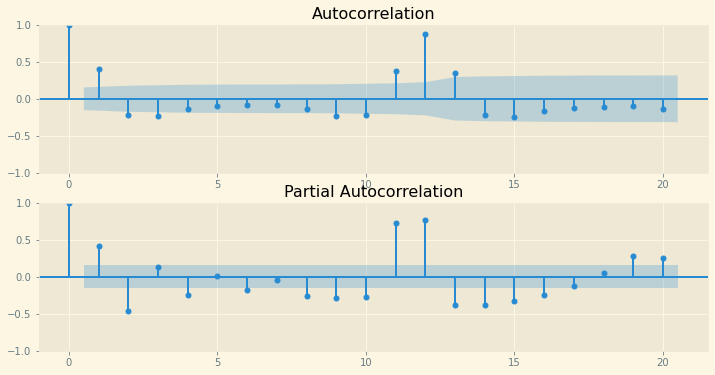

In [131]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train['z_data'].dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(train['z_data'].dropna(), ax=ax[1], lags=20)

In [135]:
len(df)-size

44

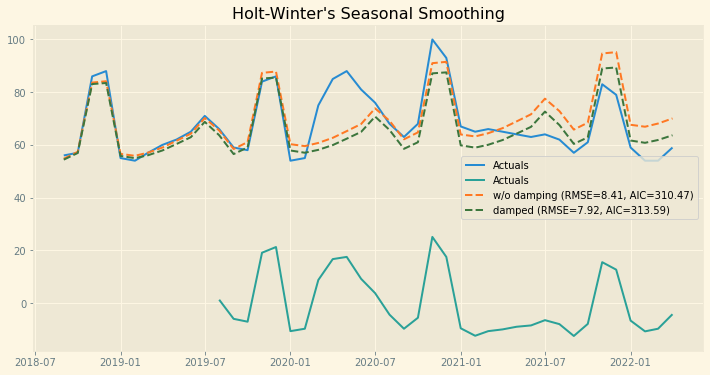

In [161]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train['walmart: (United States)'], trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train['walmart: (United States)'], trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(df)-size)
fit2 = model2.fit()
pred2 = fit2.forecast(len(df)-size)

sse1 = np.sqrt(np.mean(np.square(test['walmart: (United States)'].fillna(0).values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test['walmart: (United States)'].fillna(0).values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(train.index[0:], train.values[0:]);
ax.plot(test.index, test.values, label='Actuals');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [152]:
test

,walmart: (United States),station
Month,,
2018-09-01,56,NaN
2018-10-01,57,NaN
2018-11-01,86,NaN
2018-12-01,88,NaN
2019-01-01,55,NaN
2019-02-01,54,NaN
2019-03-01,57,NaN
2019-04-01,60,NaN
2019-05-01,62,NaN


In [42]:
train['walmart: (United States)']

Month
2004-01-01     7
2004-02-01     6
2004-03-01     7
2004-04-01     7
2004-05-01     8
              ..
2019-12-01    86
2020-01-01    54
2020-02-01    55
2020-03-01    75
2020-04-01    85
Name: walmart: (United States), Length: 196, dtype: int64

### SARIMA

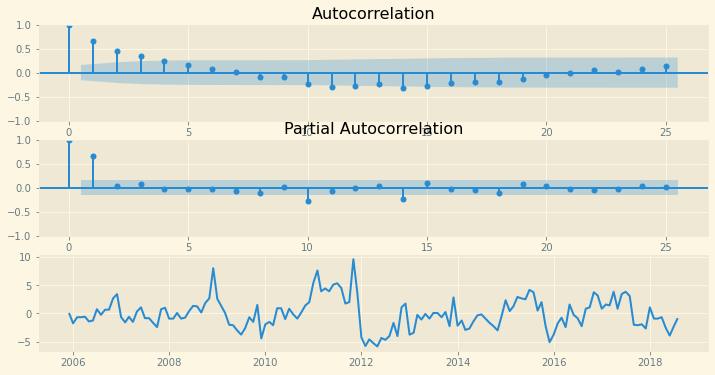

In [138]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data
train['station'] = train['walmart: (United States)'] - train['walmart: (United States)'].rolling(12).mean()

fig, ax = plt.subplots(3, figsize=(12,6))
x = (train.station.dropna() - train.station.dropna().shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [150]:
print("Possible ARIMA models suggested:")
print('SARIMAX: {} x {}'.format([0,0,1], [0,1,1,12]))
print('SARIMAX: {} x {}'.format([1,0,1], [0,1,1,12]))
print('SARIMAX: {} x {}'.format([1,0,0], [0,1,1,12]))

Possible ARIMA models suggested:
SARIMAX: [0, 0, 1] x [0, 1, 1, 12]
SARIMAX: [1, 0, 1] x [0, 1, 1, 12]
SARIMAX: [1, 0, 0] x [0, 1, 1, 12]


In [139]:
# set the typical ranges for p, d, q
p = d = q = range(0, 2)

#take all possible combination for p, d and q
pdq = list(itertools.product(p, d, q))
s_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# To find optimal parameters for the model
min=0
for param in pdq:
    for p_s in s_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df, order = param, seasonal_order = p_s, enforce_stationary = False,enforce_invertibility=False) 
            result = mod.fit()   
            print('ARIMA{}x{}12 - AIC:{}'.format(param, p_s, result.aic))
            if min==0 or min>result.aic:
                min=result.aic
                best_param=param
                best_p_s=p_s
                best=result
        except:
            continue
        
#mod = sm.tsa.statespace.SARIMAX(df, order = best_param, seasonal_order = best_p_s, enforce_stationary = False,enforce_invertibility=False) 
#result = mod.fit() 
best.summary()

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2328.2458306860444
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2075.344199099084
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1380.2743540940282
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1381.8305180947646
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1507.0656791625343
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1508.2848681125336
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1381.6220904154638
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1363.1346054431137
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2042.793151355399
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1799.282184986475
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1202.9648803778643
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1204.4802325638009
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1315.0650604828265
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1316.7994696443236
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1204.3002752524972
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1205.1173293278541
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1628.3567592791223
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1436.651908429

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:           walmart: (United States)   No. Observations:                  220
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -532.358
Date:                            Sun, 01 May 2022   AIC                           1072.716
Time:                                    08:11:23   BIC                           1086.066
Sample:                                01-01-2004   HQIC                          1078.114
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8501      0.031     27.552      0.000       0.790       0.911
ma.L1          0.2525      0.052      4.829      0.000       0.150       0.355
ma.S.L12      -0.2999      0.039     -7.598      0.000      -0.377      -0.223
sigma2         9.6560      0.495     19.508      0.000       8.686      10.626
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               298.07
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               4.52   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

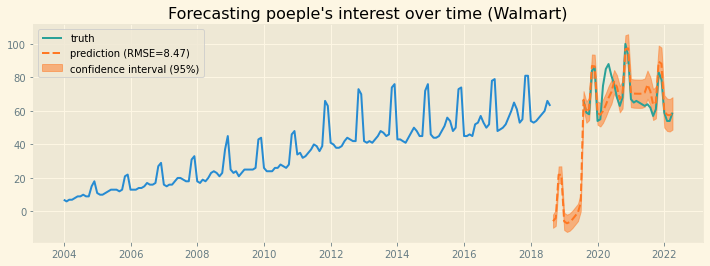

In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#train_st = train.ix[:-24, "station"]
#test_st = df.ix[-24:, "station"]
sarima_model = SARIMAX(train['station'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction("2018-9", "2022-04")
pred_mean=sarima_pred.predicted_mean
predicted_means = pred_mean.values + test['walmart: (United States)'].rolling(12).mean().fillna(0).values
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + test['walmart: (United States)'].rolling(12).mean().fillna(0).values
upper_bounds = predicted_intervals['upper station'] + test['walmart: (United States)'].rolling(12).mean().fillna(0).values
test['station'] = test['walmart: (United States)'] - test['walmart: (United States)'].rolling(12).mean()


sarima_rmse = np.sqrt(np.mean(np.square(test['station'].fillna(0).values - pred_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train['walmart: (United States)'].index, train['walmart: (United States)'].values);
ax.plot(test['station'].index, test['station'].values + test['walmart: (United States)'].rolling(12).mean().fillna(0).values, label='truth');
ax.plot(test['station'].index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test['station'].index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.5, label="confidence interval (95%)");
ax.legend();
ax.set_title("Forecasting poeple's interest over time (Walmart)");


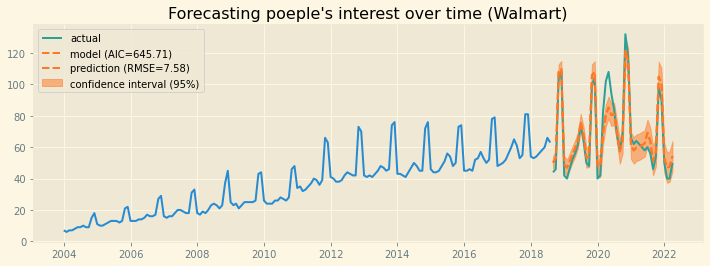

In [163]:
sarima_model = SARIMAX(train['station'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction("2018-09", "2022-04")
pred_mean=sarima_pred.predicted_mean
predicted_means = pred_mean.values + test['walmart: (United States)'].values
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + test['walmart: (United States)'].values
upper_bounds = predicted_intervals['upper station'] + test['walmart: (United States)'].values
test['station'] = test['walmart: (United States)'] - test['walmart: (United States)'].mean()

sarima_rmse = np.sqrt(np.mean(np.square(test['station'].fillna(0).values - pred_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train['walmart: (United States)'].index, train['walmart: (United States)'].values);
ax.plot(test['station'].index, test['station'].values + test['walmart: (United States)'].values, label='actual')
ax.plot(test['station'].index, predicted_means, color='#ff7823', linestyle='--', label="model (AIC={:0.2f})".format(sarima_fit.aic));
ax.plot(test['station'].index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test['station'].index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.5, label="confidence interval (95%)");
ax.legend();
ax.set_title("Forecasting poeple's interest over time (Walmart)");

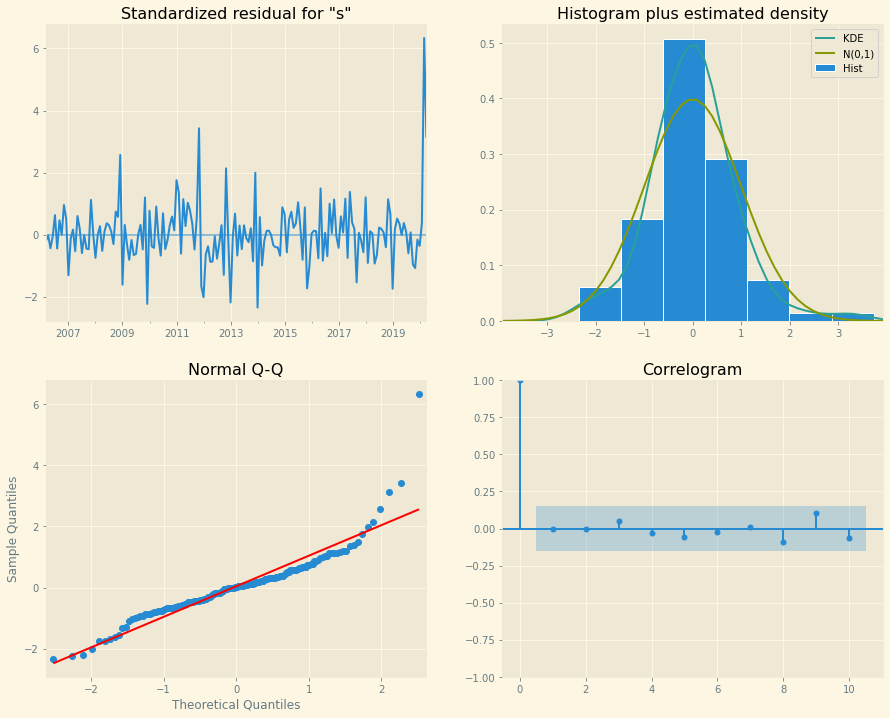

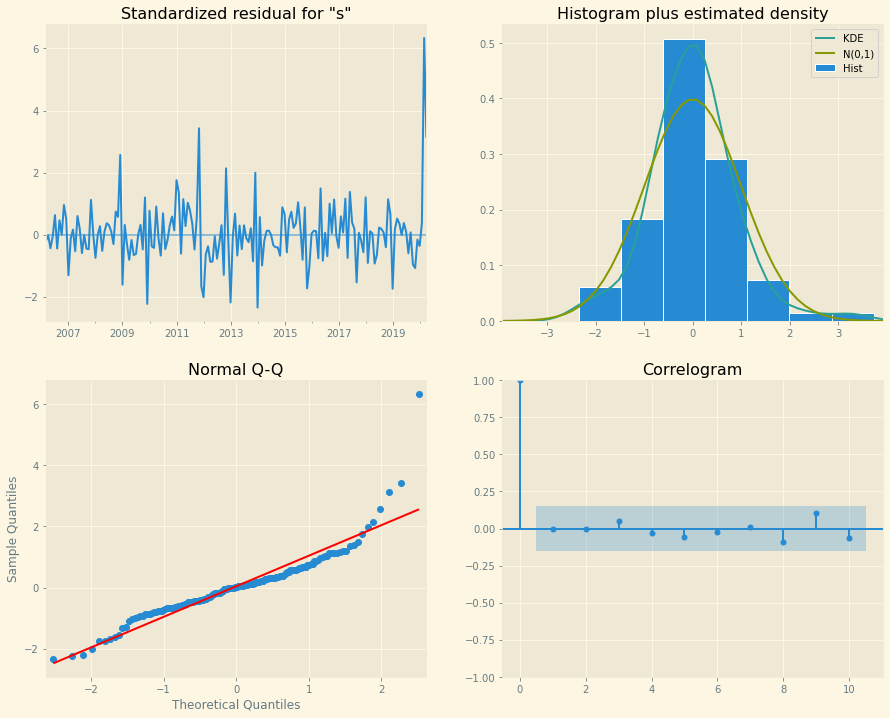

In [123]:
sarima_fit.plot_diagnostics(figsize=(15, 12))

In [143]:
test

,walmart: (United States)
Month,
2018-09-01,56
2018-10-01,57
2018-11-01,86
2018-12-01,88
2019-01-01,55
2019-02-01,54
2019-03-01,57
2019-04-01,60
2019-05-01,62


In [86]:
len(test)

24

In [93]:
pred_mean.values+test['walmart: (United States)'].rolling(12).mean().fillna(0).values

array([ 11.88327987,   8.65254509,  10.92189455,   3.94959572,
        -4.4176534 ,  -5.93318847,  20.08334266,  21.94103069,
       -10.16444514,  -9.52867513,   7.26313553,  89.59641803,
        83.47676815,  79.33996779,  80.95244816,  73.6783847 ,
        64.92566115,  62.89295706,  87.53104632,  88.2441511 ,
        55.48476676,  55.21124081,  71.00730972,  77.84305231])

In [109]:
sarima_rmse

12.97900360732966

In [101]:
np.square(test['station'].values)

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 100.        ,
        81.        ,  72.25      ,  42.25      ,  64.        ,
       156.25      ,  62.67361111, 240.25      , 160.44444444,
        44.44444444, 115.5625    ,  95.0625    ,  18.0625    ])